In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, fmin_cg
import scipy.io as sio
import statistics as stats

In [2]:
file_name = 'ex5data1.mat'

def read_file(file_name):
    data = sio.loadmat(file_name)

    # training set
    X, y = data['X'], data['y']

    # test set
    X_test, y_test = data['Xtest'], data['ytest']

    # cross-validation set
    X_CV, y_CV = data['Xval'], data['yval']


    m, n = X.shape[0], X.shape[1]
    m_test = X_test.shape[0]
    m_CV = X_CV.shape[0]
    
    return X, y, X_test, y_test, X_CV, y_CV, m, n, m_test, m_CV

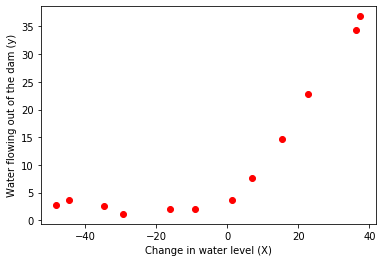

In [3]:
X, y, X_test, y_test, X_CV, y_CV, m, n, m_test, m_CV = read_file('ex5data1.mat')
plt.scatter(X.flatten(), y.flatten(), c='r')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

In [4]:
def cost(theta, X, y, lmd):
    m = X.shape[0]
    bias = np.ones((m, 1))
    X = np.append(bias, X, axis=1)
    theta = theta.reshape((theta.size, 1))
    
    # Not regularized yet
    ans = np.matmul(X, theta)
    ans = ans - y
    ans = np.matmul(ans.T, ans)
    ans = (1 / (2 * m)) * ans
    
    
    # Regularization term
    reg = np.matmul(theta[1:, ...].T, theta[1:, ...])
    reg = (lmd / (2 * m)) * reg
    
    return (ans + reg).flatten()[0]


def gradient(theta, X, y, lmd):
    m = X.shape[0]
    bias = np.ones((m, 1))
    X = np.append(bias, X, axis=1)
    
    theta = theta.reshape((theta.size, 1))
    
    # Not regularized yet
    grad = np.matmul(X, theta)
    grad = np.matmul(X.T, grad - y)
    grad = (1 / m) * grad
    
    # Regularization term
    reg = theta[1:, ...]
    reg = (lmd / m) * reg
    reg = reg.flatten()
    reg = np.insert(reg, 0, theta[0][0])
    reg = reg.reshape(theta.shape)
    
    return (grad + reg).flatten()

In [5]:
theta = np.zeros((1, n+1)).flatten()
lmd = 0

In [6]:
cost(theta, X, y, lmd)

140.95412088055392

In [7]:
gradient(theta, X, y, lmd)

array([ -11.21758933, -245.65199649])

In [8]:
theta = np.zeros((1, n+1)).flatten()
lmd = 0

theta = minimize(fun=cost, x0=theta, args=(X, y, lmd)).x

cost(theta, X, y, lmd)

22.373906495110816

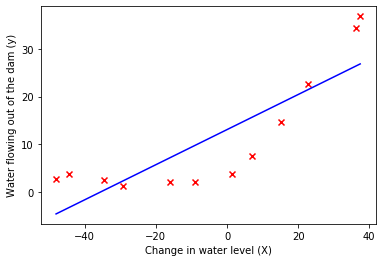

In [9]:
def h(x, theta, m, n):
    bias = 1
    theta = theta.reshape(theta.size, 1)
    x = list(x.ravel())
    x.insert(0, bias)
    x = np.array(x)
    ans = np.matmul(theta.T, x).flatten()
    return ans[0]

plt.scatter(X.flatten(), y.flatten(), c='r', marker='x')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')
x_min, x_max = min(X.flatten()), max(X.flatten())
x_arr = np.arange(x_min, x_max, 0.1)
y_arr = []
for x1 in x_arr:
    y_arr.append(h(x1, theta, m, n))
plt.plot(x_arr, y_arr, c='b')
plt.show()

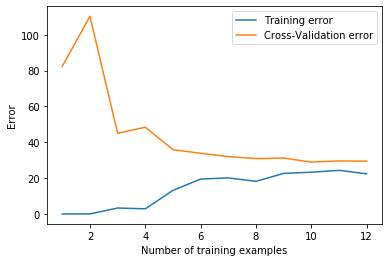

In [10]:
# getting a fit line for each number of training data and storing CV errors and train errors
tr_x = [] # training error x vals
tr_y = [] # training error y vals
cv_x = [] # cross validation error x vals
cv_y = [] # cross validation error y vals
lmd = 0

for i in range(1, m+1):
    tr_x.append(i)
    cv_x.append(i)
    my_X = X[0:i, ...]
    my_y = y[0:i, ...]
    my_theta = np.zeros((n, 1))
    my_theta = minimize(fun=cost, args=(my_X, my_y, lmd), x0=theta).x
    tr_y.append(cost(my_theta, my_X, my_y, 0))
    cv_y.append(cost(my_theta, X_CV, y_CV, 0))

plt.plot(tr_x, tr_y, label='Training error')
plt.plot(cv_x, cv_y, label='Cross-Validation error')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
plt.show()


## Polynomial Regression

In [11]:
def normalize(X):
    '''Normaliza los datos de la matriz X
    restandoles su media y dividiendolos por la desviacion estandar'''
    mu = np.mean(X, axis=0)
    X_mean = X - mu
    sigma = np.std(X, axis=0)
    X_norm = X_mean / sigma
    return X_norm, mu, sigma

def polynomial(X, p):
    m = len(X)
    for i in range(p+1):
        if i < 2:
            pass
        else:
            power = np.power(X[:,0],i)
            power =  power.reshape((len(X), 1))
            X = np.append(X,power, axis=1)
    return X



X, y, X_test, y_test, X_CV, y_CV, m, n, m_test, m_CV = read_file('ex5data1.mat')

# before normalizing and polynomial mapping
original_X = read_file('ex5data1.mat')[0]

X, mu, sigma = normalize(X)
degree = 8
X = polynomial(X, degree)
lmd = 0
theta = np.zeros((degree+1, 1)).flatten()

In [12]:
theta = minimize(fun=cost, x0=theta, args=(X, y, lmd)).x

cost(theta,X,y,lmd)

0.02889024049348536

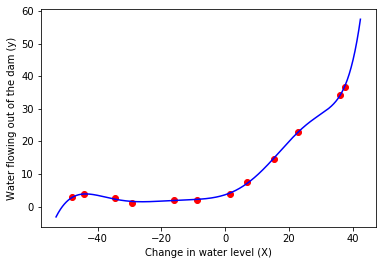

In [13]:
def map_single_feature(x1, degree):
    res = []
    for i in range(1, degree+1):
        res.append(x1**i)
    arr = np.array(res)
    return arr.reshape((arr.size, 1))

plt.scatter(original_X.flatten(), y.flatten(), c='r')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')
x_min, x_max = min(original_X.flatten()) - 5, max(original_X.flatten()) + 5
x_arr = np.arange(x_min, x_max, 0.1)
y_arr = []
for x1 in x_arr:
    # normalize:
    x1 = (x1 - mu) / sigma
    x1 = map_single_feature(x1, degree)
    y_arr.append(h(x1, theta, m, degree))
plt.plot(x_arr, y_arr, c='b')
plt.show()

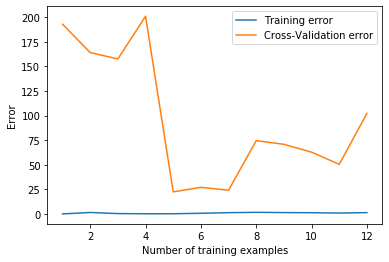

In [14]:
tr_x = [] # training error x vals
tr_y = [] # training error y vals
cv_x = [] # cross validation error x vals
cv_y = [] # cross validation error y vals
lmd = 0

X_CV,_,_ = normalize(X_CV)
X_CV = polynomial(X_CV, degree)
degree = 8

for i in range(1, m+1):
    tr_x.append(i)
    cv_x.append(i)
    mytheta = np.zeros((degree+1, 1)).flatten()
    mytheta = minimize(method='CG', fun=cost, jac=gradient, x0=mytheta, args=(X[0:i, ...], y[0:i, ...], lmd)).x
    tr_y.append(cost(mytheta, X[0:i, ...], y[0:i], 0))
    cv_y.append(cost(mytheta, X_CV, y_CV, 0))
    
plt.plot(tr_x, tr_y, label='Training error')
plt.plot(cv_x, cv_y, label='Cross-Validation error')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
    
plt.show()

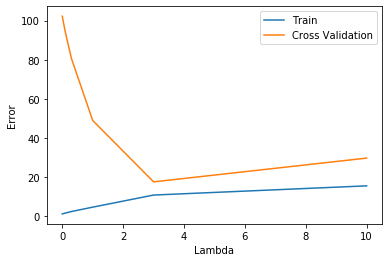

In [15]:
degree = 8
tr_x = [] # training error x vals
tr_y = [] # training error y vals
cv_x = [] # cross validation error x vals
cv_y = [] # cross validation error y vals

for lmd in ( 0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10):
    tr_x.append(lmd)
    cv_x.append(lmd)
    
    X, y, X_test, y_test, X_CV, y_CV, m, n, m_test, m_CV = read_file('ex5data1.mat')
    
    X, _, _ = normalize(X)
    X = polynomial(X, degree)
    X_CV,_,_ = normalize(X_CV)
    X_CV = polynomial(X_CV, degree)
    
    theta = np.zeros((degree+1, 1)).flatten()
    theta = minimize(method='CG', fun=cost, jac=gradient, x0=theta, args=(X, y, lmd)).x
    
    tr_y.append(cost(theta, X, y, lmd))
    cv_y.append(cost(theta, X_CV, y_CV, lmd))
    
plt.plot(tr_x, tr_y, label='Train')
plt.plot(cv_x, cv_y, label='Cross Validation')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.legend()
plt.show()